# import

In [1]:
from simCAS import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Read real data and calculate the statistics

In [2]:
# read the anndata
prefix_='Buenrostro_2018'
resultdir='/data1/lichen/code/second/scATAC_integration/data/scATACdata_total/process/{0}/'.format(prefix_)
adata=sc.read(resultdir+'adata_forsimulation.h5ad')

peak_mean=np.log(cal_pm(adata)+1)
lib_size=np.log(cal_lib(adata)+1)
nozero=np.log(cal_nozero(adata)+1)

# setting the input tree

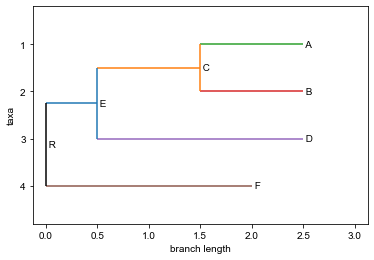

In [3]:

tab10=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
       '#e377c2','#7f7f7f','#bcbd22','#17becf']
tree_text='((((A:1, B:1)C:1,D:2)E:0.5, F:2)R)'
tree = Phylo.read(StringIO(tree_text), "newick")

clades = [i for i in tree.find_clades()]
branch_clades=[i for i in clades if i.branch_length]
branches=[tree.get_path(i)[-2:] for i in branch_clades]

for i in range(len(branch_clades)):
    branch_clades[i].color=tab10[i]
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
Phylo.draw(tree,axes=ax1)

# generate synthetic data

the meanings of parameters are shown below:

In [4]:
?simCAS_generate

Signature:
simCAS_generate(
    peak_mean=None,
    lib_size=None,
    nozero=None,
    n_peak=100000.0,
    n_cell_total=1500,
    rand_seed=2022,
    zero_prob=0.5,
    zero_set='all',
    effect_mean=0,
    effect_sd=1,
    min_popsize=300,
    min_pop=None,
    tree_text=None,
    pops_name=None,
    pops_size=None,
    embed_mean_same=1,
    embed_sd_same=0.5,
    embed_mean_diff=1,
    embed_sd_diff=0.5,
    len_cell_embed=12,
    n_embed_diff=10,
    n_embed_same=2,
    simu_type='discrete',
    correct_iter=2,
    activation='exp_linear',
    two_embeds=True,
    adata_dir=None,
    lib_simu='estimate',
    distribution='Poisson',
    bw_pm=0.0001,
    bw_lib=0.05,
    bw_nozero=0.05,
    real_param=False,
    K=None,
    A=None,
)
Docstring:
generate scCAS data with three modes: pseudo-cell-type mode, discrete mode, continuous mode.

Parameter
----------
peak_mean: 1D numpy array, default=None
    Real peak mean of scCAS data. Used for statistical estimation.
lib_size: 1D nump

In [5]:
adata_final=simCAS_generate(peak_mean=peak_mean,lib_size=lib_size,nozero=nozero,n_peak=adata.shape[1],
                n_cell_total=1500,rand_seed=2022,tree_text=tree_text,simu_type='continuous',
                    activation='exp_linear')

**********start generate effect vector...**********
**********generate effect finished!**********
**********start generate cell embedding...**********
simulation type is continuous
**********generate cell embedding finished**********
**********start generate counts...**********
**********start ZIP correction...**********
**********ZIP correction finished!**********
**********generate counts finshed!**********


In [6]:
adata_final

AnnData object with n_obs × n_vars = 1500 × 169221
    obs: 'celltype'

## UMAP visualization

In [7]:
import episcanpy.api as epi

In [8]:
# Perform Signac TF-IDF (count_mat: peak*cell)
def tfidf2(count_mat): 
    tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
    signac_mat = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / (np.sum(count_mat,axis=1)+1) ).reshape(-1,1), (1,count_mat.shape[1]))))
    return scipy.sparse.csr_matrix(signac_mat)

**finish TF-IDF**


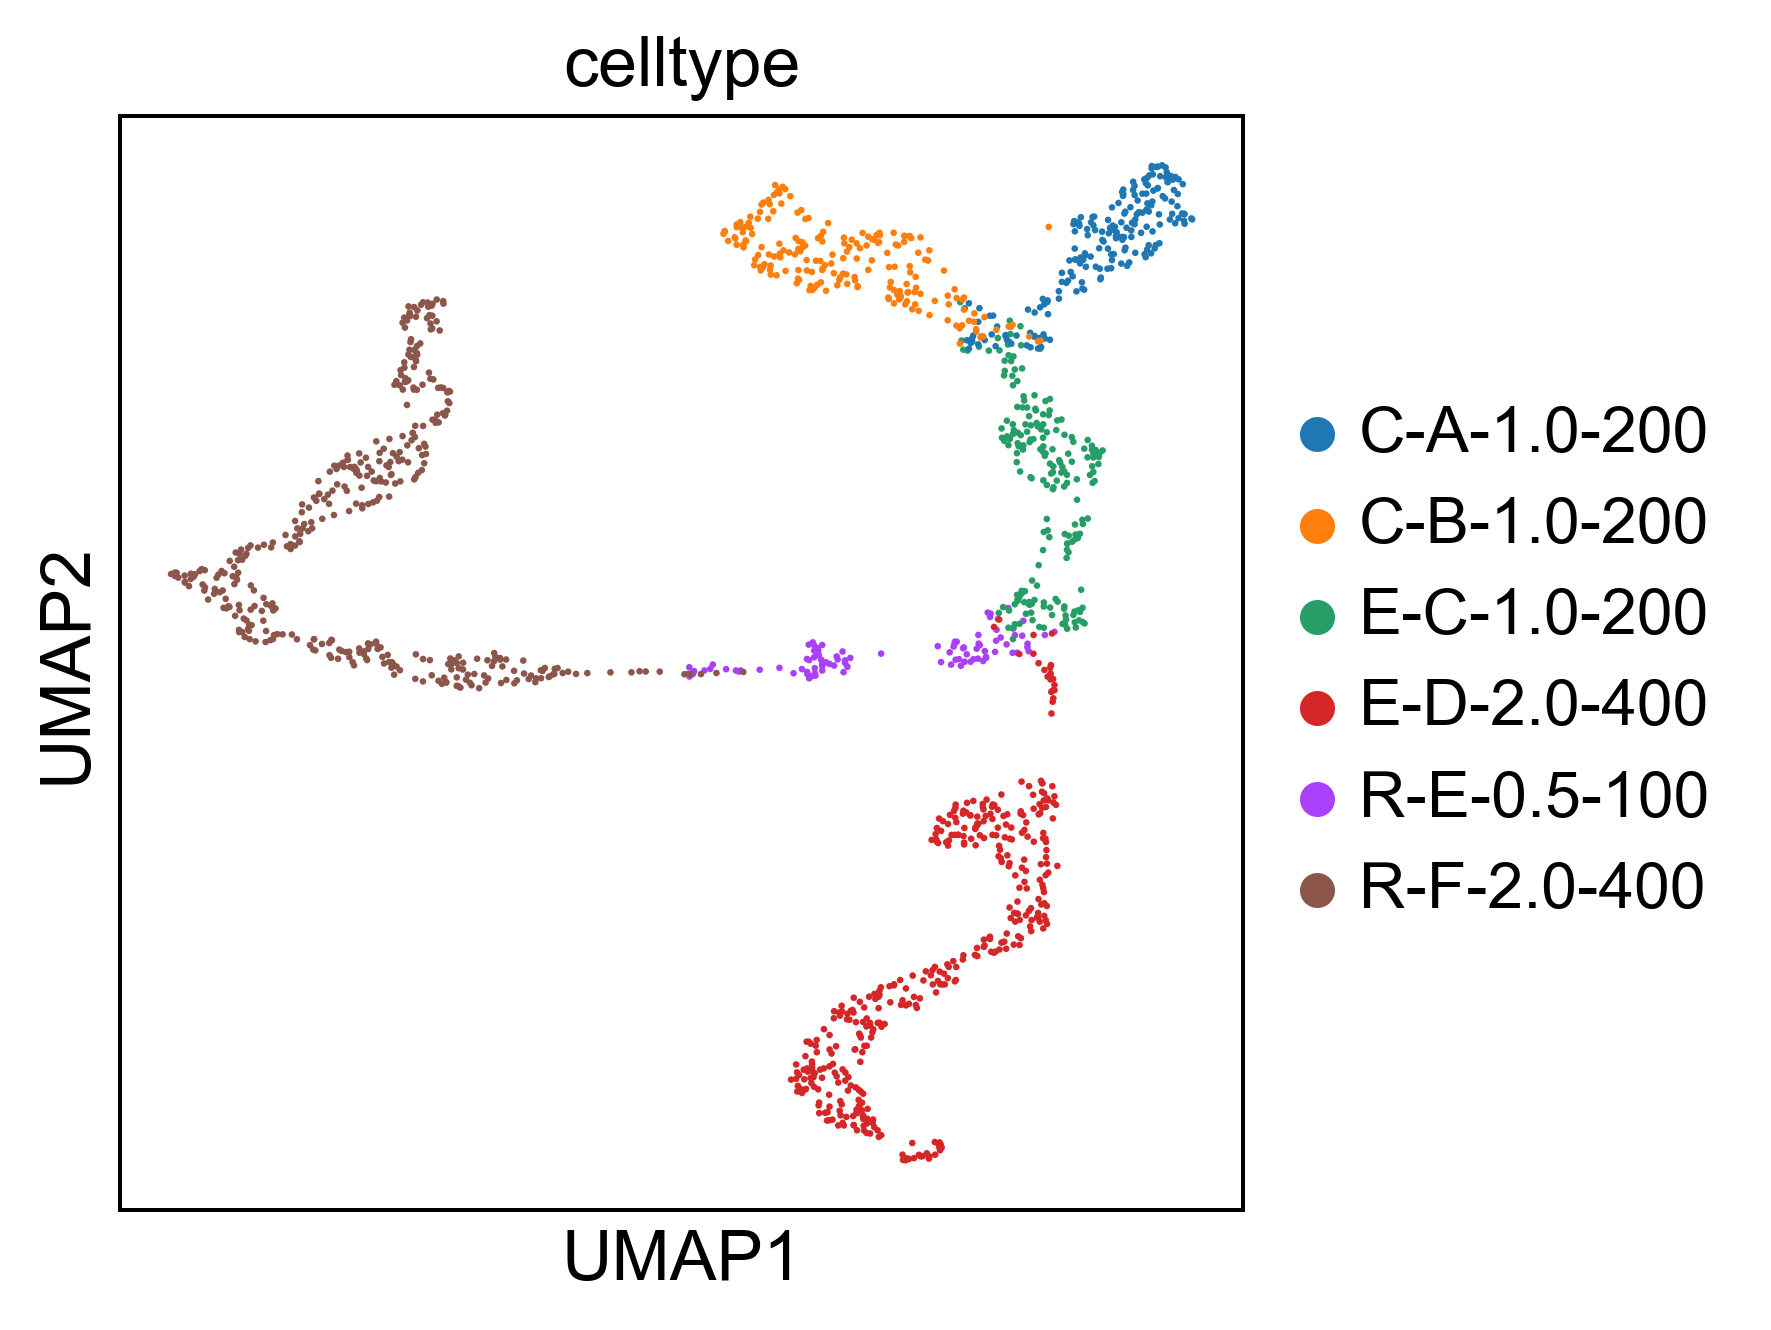

In [9]:
nb_feature_selected = 50000
seed=2022
adata_final = epi.pp.select_var_feature(adata_final,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

adata_final.X=tfidf2(adata_final.X.T).T
print("**finish TF-IDF**")

#-----plot umap
sc.tl.pca(adata_final, n_comps =50,svd_solver='arpack',random_state=seed)
sc.pp.neighbors(adata_final, n_neighbors=10, n_pcs=20,random_state=seed)
sc.tl.umap(adata_final,random_state=seed)
sc.tl.leiden(adata_final,random_state=seed)

sc.settings.set_figure_params(dpi=180,facecolor='white',vector_friendly=False)

sc.pl.umap(adata_final, color=['celltype'],size=7)